# Find precipitation value for pulsed and upslope storms

In [2]:
import sys
sys.path.append('/uio/kant/geo-metos-u7/franzihe/Documents/Thesis/Python')

import numpy as np
import netCDF4
import pandas as pd
import matplotlib.pyplot as plt

import createFolder as cF
np.warnings.filterwarnings('ignore')



In [3]:
m = ['11', '12', '01', '02', '03']
station = 'Haukeliseter'

In [4]:
savefig = 0
if savefig == 1:
    figdir = '../../Figures/Weathermast_MEPS/%s/wind_dir' %(station)
    cF.createFolder('%s/' %figdir)
form = 'png'

### Minuelty data

In [5]:
obs_f = dict()
obs_double_fence_acc_mean = dict()
obs_wind_dir_10m   = dict()
obs_wind_speed_10m = dict()
obs_dofe_acc   = dict()
obs_wind_dir   = dict()
obs_wind_speed = dict() 
obs_dofe_acc_rolling = dict()
obs_wind_dir_rolling = dict()
obs_wind_speed_rolling = dict()
obs_diff = dict()
obs_westerly_idx = dict()
obs_easterly_idx = dict()
obs_westerly = dict()
obs_easterly = dict()
obs_total_precip = dict()
obs_precip_west  = dict()
obs_precip_east  = dict()

for month in m:
    if month == '11':
        t = np.arange(7,31)
    if month == '12' or month == '01' or month == '03':
        t = np.arange(1,32)
    if month == '02':
        t = np.arange(1,29)
    if month == '11' or month == '12':
        year = '2016'
    if month == '01' or month == '02' or month == '03':
        year = '2017'
    

    for day in t:
        
        if day < 10:
            day = '0%s' %day
        else:
            day = '%s' %day

        obs_dirnc = '../../Data/Weathermast/Met_%s%s%s_%s.nc' %(year,month,day,station)
        obs_f[int(year+month+day)] = netCDF4.Dataset(obs_dirnc, 'r')

        obs_double_fence_acc_mean[int(year+month+day)] = (np.nanmean(obs_f[int(year+month+day)].variables['double_fence_accum'][:], axis=1))
        obs_wind_dir_10m[int(year+month+day)]   = (obs_f[int(year+month+day)].variables['10m_wind_dir_mast1'][:])
        obs_wind_speed_10m[int(year+month+day)] = (obs_f[int(year+month+day)].variables['10m_wind_speed_mast1'][:])
        
        obs_f[int(year+month+day)].close
        
        ## Create a rolling mean to smoothen out the data
        # attach the last 9 minutes from the previous day to calculate the rolling mean every 10 minutes
        if month != '11' and day == '01':
            if month == '12':
                previous_day = '30'
            elif month == '01' or month == '02':
                previous_day = '31'
            elif month == '03':
                previous_day = '28'
            if month == '01':
                previous_month = '12'
                previous_year = str(int(year)-1)
            elif month == '12':
                previous_month = str(int(month)-1)
                previous_year = year
            else:
                previous_month = '0%s' %(int(month)-1)
                previous_year = year
            
        elif int(day)-1 < 10:
            previous_day = '0%s' %(int(day)-1)
            previous_month = month
            previous_year = year
        else:
            previous_day = '%s' %(int(day)-1)
            previous_month = month
            previous_year = year
        if year == '2016' and month == '11' and day == '07':
            continue
        else:
            pp = (np.concatenate((obs_double_fence_acc_mean[int(previous_year+previous_month+previous_day)][-9:],
                                  obs_double_fence_acc_mean[int(year+month+day)][:])))
            obs_dofe_acc[int(year+month+day)] = (pp)
            wd = (np.concatenate((obs_wind_dir_10m[int(previous_year+previous_month+previous_day)][-9:], 
                                  obs_wind_dir_10m[int(year+month+day)][:])))
            obs_wind_dir[int(year+month+day)] = (wd)
            ws = (np.concatenate((obs_wind_speed_10m[int(previous_year+previous_month+previous_day)][-9:], 
                                  obs_wind_speed_10m[int(year+month+day)][:])))
            obs_wind_speed[int(year+month+day)] = (ws)
        # Calculate the moving average. That is, take
        # the first ten values, average them, 
        # then drop the first and add the eleventh, etc.
        obs_dofe_acc[int(year+month+day)] = pd.DataFrame(np.array(obs_dofe_acc[int(year+month+day)])[:])
        obs_dofe_acc_rolling[int(year+month+day)] = obs_dofe_acc[int(year+month+day)].rolling(window=10,
                                                                                              min_periods= 7,
                                                                                              axis=0).mean()
        obs_dofe_acc_rolling[int(year+month+day)] = obs_dofe_acc_rolling[int(year+month+day)].values
        obs_dofe_acc_rolling[int(year+month+day)] = np.array(obs_dofe_acc_rolling[int(year+month+day)])[9:,:]

        obs_wind_dir[int(year+month+day)] = pd.DataFrame(np.array(obs_wind_dir[int(year+month+day)])[:])
        obs_wind_dir_rolling[int(year+month+day)] = obs_wind_dir[int(year+month+day)].rolling(window=10,
                                                                                              min_periods=7,
                                                                                              axis=0).mean()
        obs_wind_dir_rolling[int(year+month+day)] = obs_wind_dir_rolling[int(year+month+day)].values
        obs_wind_dir_rolling[int(year+month+day)] = np.array(obs_wind_dir_rolling[int(year+month+day)])[9:,:]

        obs_wind_speed[int(year+month+day)] = pd.DataFrame(np.array(obs_wind_speed[int(year+month+day)])[:])
        obs_wind_speed_rolling[int(year+month+day)] = obs_wind_speed[int(year+month+day)].rolling(window=10,
                                                                                                  min_periods=7,
                                                                                                  axis=0).mean()
        obs_wind_speed_rolling[int(year+month+day)] = obs_wind_speed_rolling[int(year+month+day)].values
        obs_wind_speed_rolling[int(year+month+day)] = np.array(obs_wind_speed_rolling[int(year+month+day)])[9:,:]
        
        
        ## calculate the precipitation difference, since the minutelty data is accumulated from the beginning
        obs_diff[int(year+month+day)] = np.empty(shape=(obs_dofe_acc_rolling[int(year+month+day)].shape))#/60))
        obs_diff[int(year+month+day)][:] =  np.nan

        for i in np.arange(0,obs_dofe_acc_rolling[int(year+month+day)].shape[0]-1):#/60):
            obs_diff[int(year+month+day)][int(i),:] = obs_dofe_acc_rolling[int(year+month+day)][int(i)+1] - \
                                                      obs_dofe_acc_rolling[int(year+month+day)][int(i)]


        # Find wind regimes and associated precip amount
        IDX = np.arange(obs_wind_dir_rolling[int(year+month+day)].shape[0])

        ## find all obs_westerly regimes (202.5 - 22.5 deg) 
        obs_westerly_idx[int(year+month+day)]  = IDX[np.logical_or(np.logical_and((obs_wind_dir_rolling[int(year+month+day)][:,0] >= 202.5), 
                                                                              (obs_wind_dir_rolling[int(year+month+day)][:,0] <= 360)),
                                                              (obs_wind_dir_rolling[int(year+month+day)][:,0] <22.5))]
        ## find all obs_easterly regimes (22.5 - 202.5 deg)
        obs_easterly_idx[int(year+month+day)]  = IDX[np.logical_and((obs_wind_dir_rolling[int(year+month+day)][:,0] >= 22.5),
                                                                (obs_wind_dir_rolling[int(year+month+day)][:,0] < 202.5))]

        ## find indices for all obs_westerly regimes 
        sub_idx = []

        for i in range(0,obs_westerly_idx[int(year+month+day)] .shape[0]-1):
            if obs_westerly_idx[int(year+month+day)] [i]+1 == obs_westerly_idx[int(year+month+day)] [i+1]:
                continue
            else:
                ##print(i)
                sub_idx.append(i)
    
    #        #print([int(year+month+day)], obs_westerly_idx[int(year+month+day)], sub_idx)
        
        
        ## find westerlies which are < 29 min and assign them to obs_easterly wind regime
        if len(obs_westerly_idx[int(year+month+day)]) == 0 and len(sub_idx) == 0:     # westerlies do not exist
            obs_westerly[int(year+month+day)] = []
            obs_easterly[int(year+month+day)] = obs_easterly_idx[int(year+month+day)]
#            #print('No obs_westerly wind on %s' %(int(year+month+day)))
        elif len(obs_westerly_idx[int(year+month+day)]) != 0 and len(sub_idx) == 0:   # westerlies exist only for one time period a day
            obs_westerly[int(year+month+day)] = []
      #      obs_easterly[int(year+month+day)] = []
            obs_easterly[int(year+month+day)] = obs_easterly_idx[int(year+month+day)]
            
            obs_westerly_duration = obs_westerly_idx[int(year+month+day)][-1] - obs_westerly_idx[int(year+month+day)][0]
            if obs_westerly_duration >= 28:
                obs_westerly[int(year+month+day)] = np.concatenate((obs_westerly[int(year+month+day)],
                                                                obs_westerly_idx[int(year+month+day)][:]))
            elif obs_westerly_duration < 28:
                obs_easterly[int(year+month+day)] = np.concatenate((obs_easterly[int(year+month+day)],
                                                                obs_westerly_idx[int(year+month+day)][:]))
        else:
            obs_westerly[int(year+month+day)] = []
         #   obs_easterly[int(year+month+day)] = []
            obs_easterly[int(year+month+day)] = obs_easterly_idx[int(year+month+day)]

            for i in np.arange(0,np.array(sub_idx).shape[0]+1):                # westerlies and easterlies interchange daily
                if i == 0:
                    obs_westerly_duration = (obs_westerly_idx[int(year+month+day)] [ sub_idx[0]] - \
                                         obs_westerly_idx[int(year+month+day)] [0])
                elif i == np.array(sub_idx).shape[0]:
                    obs_westerly_duration = (obs_westerly_idx[int(year+month+day)] [-1] - \
                                         obs_westerly_idx[int(year+month+day)] [ sub_idx[np.array(sub_idx).shape[0]-1]+1])
                else:
                    obs_westerly_duration = (obs_westerly_idx[int(year+month+day)] [ sub_idx[i]] - \
                                         obs_westerly_idx[int(year+month+day)] [ sub_idx[i-1]+1])
                if obs_westerly_duration >= 28:
                    if i == 0:
                        obs_westerly[int(year+month+day)] = np.concatenate((obs_westerly[int(year+month+day)], 
                                                                        obs_westerly_idx[int(year+month+day)] [ 0: sub_idx[0]+1]))
            #            #print(obs_westerly_duration, RR_obs_westerly)
                    elif i == np.array(sub_idx).shape[0]:
                        obs_westerly[int(year+month+day)] = np.concatenate((obs_westerly[int(year+month+day)], 
                                                                        obs_westerly_idx[int(year+month+day)] [ sub_idx[np.array(sub_idx).shape[0]-1]+1 : ]))
             #           #print(obs_westerly_duration, RR_obs_westerly)
                    else:
                        obs_westerly[int(year+month+day)] = np.concatenate((obs_westerly[int(year+month+day)], 
                                                                        obs_westerly_idx[int(year+month+day)] [ sub_idx[i-1]+1 : sub_idx[i]+1]))
              #          #print(obs_westerly_duration, RR_obs_westerly)
                elif obs_westerly_duration < 28:
                    if i == 0:
                        obs_easterly[int(year+month+day)] = np.concatenate((obs_easterly[int(year+month+day)], 
                                                                        obs_westerly_idx[int(year+month+day)] [ 0: sub_idx[0]+1]))
                    elif i == np.array(sub_idx).shape[0]:
                        obs_easterly[int(year+month+day)] = np.concatenate((obs_easterly[int(year+month+day)],
                                                                        obs_westerly_idx[int(year+month+day)] [ sub_idx[np.array(sub_idx).shape[0]-1]+1 : ]))
                    else:
                   # #print(obs_westerly_duration)
                        obs_easterly[int(year+month+day)] = np.concatenate((obs_easterly[int(year+month+day)],
                                                                        obs_westerly_idx[int(year+month+day)] [ sub_idx[i-1]+1 : sub_idx[i]+1]))
        

        if len(obs_westerly[int(year+month+day)]) == 0:    # only easterlies
            obs_easterly[int(year+month+day)]  = obs_easterly[int(year+month+day)].astype(int)

            #print([int(year+month+day)], 
             #     'total precipitation [mm/24h]:', 
              #    np.round(np.nansum(obs_diff[int(year+month+day)][obs_easterly_idx[int(year+month+day)],:]) + \
               #            np.nansum(obs_diff[int(year+month+day)][obs_westerly_idx[int(year+month+day)],:]),2 ),
                #  'obs_easterly [mm/24h]:', 
                 # np.round(np.nansum(obs_diff[int(year+month+day)][obs_easterly[int(year+month+day)],:]),2),
                  #'obs_westerly [mm/24h]:', 
            #      np.round(len(obs_westerly[int(year+month+day)]),2))
        elif len(obs_easterly[int(year+month+day)]) == 0:  # only westerlies
            obs_westerly[int(year+month+day)]  = obs_westerly[int(year+month+day)].astype(int)

            #print([int(year+month+day)], 
             #     'total precipitation [mm/24h]:', 
              #    np.round(np.nansum(obs_diff[int(year+month+day)][obs_easterly_idx[int(year+month+day)],:]) + \
               #            np.nansum(obs_diff[int(year+month+day)][obs_westerly_idx[int(year+month+day)],:]),2 ),
                #  'obs_easterly [mm/24h]:', 
                 # np.round(len(obs_easterly[int(year+month+day)]),2),
                  #'obs_westerly [mm/24h]:', 
            #      np.round(np.nansum(obs_diff[int(year+month+day)][obs_westerly[int(year+month+day)],:]),2))
        else:    # both easterlies and westerlies
            obs_easterly[int(year+month+day)]  = obs_easterly[int(year+month+day)].astype(int)
            obs_westerly[int(year+month+day)]  = obs_westerly[int(year+month+day)].astype(int)
            
            #print([int(year+month+day)], 
             #     'total precipitation [mm/24h]:', 
              #    np.round(np.nansum(obs_diff[int(year+month+day)][obs_easterly_idx[int(year+month+day)],:]) + \
               #            np.nansum(obs_diff[int(year+month+day)][obs_westerly_idx[int(year+month+day)],:]),2 ),
                #  'obs_easterly [mm/24h]:', 
                 # np.round(np.nansum(obs_diff[int(year+month+day)][obs_easterly[int(year+month+day)],:]),2),
                  #'obs_westerly [mm/24h]:', 
            #      np.round(np.nansum(obs_diff[int(year+month+day)][obs_westerly[int(year+month+day)],:]),2))
            
        # assign sum values to days
        obs_total_precip[int(year+month+day)] = np.nansum(obs_diff[int(year+month+day)][obs_easterly_idx[int(year+month+day)],:]) + \
                                                np.nansum(obs_diff[int(year+month+day)][obs_westerly_idx[int(year+month+day)],:])
        obs_precip_east[int(year+month+day)] = np.nansum(obs_diff[int(year+month+day)][obs_easterly[int(year+month+day)],:])
        obs_precip_west[int(year+month+day)] = np.nansum(obs_diff[int(year+month+day)][obs_westerly[int(year+month+day)],:])

In [200]:
year = '2016'
month = '12'
day = '22'

In [201]:
obs_easterly[int(year+month+day)].shape

(0,)

In [202]:
obs_westerly[int(year+month+day)].shape

(1440,)

In [203]:
IDX2 = np.arange(obs_westerly[int(year+month+day)].shape[0])
IDX3 = np.arange(obs_easterly[int(year+month+day)].shape[0])

In [204]:
IDX2.shape

(1440,)

In [205]:
west_WS_0_4 = IDX2[np.logical_and( obs_wind_speed_rolling[int(year+month+day)][obs_westerly[int(year+month+day)],0] >= 0, 
                     obs_wind_speed_rolling[int(year+month+day)][obs_westerly[int(year+month+day)],0] < 4 )]
west_WS_0_4, np.nansum(obs_diff[int(year+month+day)][obs_westerly[int(year+month+day)][west_WS_0_4]])

(array([83, 84, 85, 86]), 0.03899999999998727)

In [206]:
east_WS_0_4 = IDX3[np.logical_and( obs_wind_speed_rolling[int(year+month+day)][obs_easterly[int(year+month+day)],0] >= 0, 
                     obs_wind_speed_rolling[int(year+month+day)][obs_easterly[int(year+month+day)],0] < 4 )]
east_WS_0_4, np.nansum(obs_diff[int(year+month+day)][obs_easterly[int(year+month+day)][east_WS_0_4]])

(array([], dtype=int64), 0.0)

In [207]:
west_WS_4_8 = IDX2[np.logical_and( obs_wind_speed_rolling[int(year+month+day)][obs_westerly[int(year+month+day)],0] >= 4, 
                     obs_wind_speed_rolling[int(year+month+day)][obs_westerly[int(year+month+day)],0] < 8 )]
west_WS_4_8.shape, np.nansum(obs_diff[int(year+month+day)][obs_westerly[int(year+month+day)][west_WS_4_8]])

((274,), 9.151333333333923)

In [208]:
east_WS_4_8 = IDX3[np.logical_and( obs_wind_speed_rolling[int(year+month+day)][obs_easterly[int(year+month+day)],0] >= 4, 
                     obs_wind_speed_rolling[int(year+month+day)][obs_easterly[int(year+month+day)],0] < 8 )]
east_WS_4_8.shape, np.nansum(obs_diff[int(year+month+day)][obs_easterly[int(year+month+day)][east_WS_4_8]])

((0,), 0.0)

In [209]:
west_WS_8_12 = IDX2[np.logical_and( obs_wind_speed_rolling[int(year+month+day)][obs_westerly[int(year+month+day)],0] >= 8, 
                     obs_wind_speed_rolling[int(year+month+day)][obs_westerly[int(year+month+day)],0] < 12 )]
west_WS_8_12.shape, np.nansum(obs_diff[int(year+month+day)][obs_westerly[int(year+month+day)][west_WS_8_12]])

((1073,), 13.209666666666749)

In [210]:
east_WS_8_12 = IDX3[np.logical_and( obs_wind_speed_rolling[int(year+month+day)][obs_easterly[int(year+month+day)],0] >= 8, 
                     obs_wind_speed_rolling[int(year+month+day)][obs_easterly[int(year+month+day)],0] < 12 )]
east_WS_8_12.shape, np.nansum(obs_diff[int(year+month+day)][obs_easterly[int(year+month+day)][east_WS_8_12]])

((0,), 0.0)

In [211]:
west_WS_12_16 = IDX2[np.logical_and( obs_wind_speed_rolling[int(year+month+day)][obs_westerly[int(year+month+day)],0] >= 12, 
                     obs_wind_speed_rolling[int(year+month+day)][obs_westerly[int(year+month+day)],0] < 16 )]
west_WS_12_16.shape, np.nansum(obs_diff[int(year+month+day)][obs_westerly[int(year+month+day)][west_WS_12_16]])

((89,), 0.6879999999997608)

In [212]:
east_WS_12_16 = IDX3[np.logical_and( obs_wind_speed_rolling[int(year+month+day)][obs_easterly[int(year+month+day)],0] >= 12, 
                     obs_wind_speed_rolling[int(year+month+day)][obs_easterly[int(year+month+day)],0] < 16 )]
east_WS_12_16.shape, np.nansum(obs_diff[int(year+month+day)][obs_easterly[int(year+month+day)][east_WS_12_16]])

((0,), 0.0)

In [213]:
west_WS_16_20 = IDX2[np.logical_and( obs_wind_speed_rolling[int(year+month+day)][obs_westerly[int(year+month+day)],0] >= 16, 
                     obs_wind_speed_rolling[int(year+month+day)][obs_westerly[int(year+month+day)],0] < 20 )]
west_WS_16_20.shape, np.nansum(obs_diff[int(year+month+day)][obs_westerly[int(year+month+day)][west_WS_16_20]])

((0,), 0.0)

In [214]:
east_WS_16_20 = IDX3[np.logical_and( obs_wind_speed_rolling[int(year+month+day)][obs_easterly[int(year+month+day)],0] >= 16, 
                     obs_wind_speed_rolling[int(year+month+day)][obs_easterly[int(year+month+day)],0] < 20 )]
east_WS_16_20.shape, np.nansum(obs_diff[int(year+month+day)][obs_easterly[int(year+month+day)][east_WS_16_20]])

((0,), 0.0)

In [215]:
west_WS_20 = IDX2[( obs_wind_speed_rolling[int(year+month+day)][obs_westerly[int(year+month+day)],0] >= 20)]
west_WS_20.shape, np.nansum(obs_diff[int(year+month+day)][obs_westerly[int(year+month+day)][west_WS_20]])

((0,), 0.0)

In [216]:
east_WS_20 = IDX3[( obs_wind_speed_rolling[int(year+month+day)][obs_easterly[int(year+month+day)],0] >= 20)]
east_WS_20.shape, np.nansum(obs_diff[int(year+month+day)][obs_easterly[int(year+month+day)][east_WS_20]])

((0,), 0.0)

In [217]:
west_WS_0_4.shape[0]+west_WS_4_8.shape[0]+west_WS_8_12.shape[0]+west_WS_12_16.shape[0]+west_WS_16_20.shape[0]+west_WS_20.shape[0]

1440

In [218]:
east_WS_0_4.shape[0]+east_WS_4_8.shape[0]+east_WS_8_12.shape[0]+east_WS_12_16.shape[0]+east_WS_16_20.shape[0]+east_WS_20.shape[0]

0

In [219]:
pre_west_ws = [ 
    [ np.nansum(obs_diff[int(year+month+day)][obs_westerly[int(year+month+day)][west_WS_0_4]]) , np.nansum(obs_diff[int(year+month+day)][obs_easterly[int(year+month+day)][east_WS_0_4]])], \
    [ np.nansum(obs_diff[int(year+month+day)][obs_westerly[int(year+month+day)][west_WS_4_8]]) , np.nansum(obs_diff[int(year+month+day)][obs_easterly[int(year+month+day)][east_WS_4_8]])], \
    [ np.nansum(obs_diff[int(year+month+day)][obs_westerly[int(year+month+day)][west_WS_8_12]]) ,np.nansum(obs_diff[int(year+month+day)][obs_easterly[int(year+month+day)][east_WS_8_12]])], \
    [ np.nansum(obs_diff[int(year+month+day)][obs_westerly[int(year+month+day)][west_WS_12_16]]),np.nansum(obs_diff[int(year+month+day)][obs_easterly[int(year+month+day)][east_WS_12_16]])], \
    [ np.nansum(obs_diff[int(year+month+day)][obs_westerly[int(year+month+day)][west_WS_16_20]]),np.nansum(obs_diff[int(year+month+day)][obs_easterly[int(year+month+day)][east_WS_16_20]])], \
    [ np.nansum(obs_diff[int(year+month+day)][obs_westerly[int(year+month+day)][west_WS_20]]),   np.nansum(obs_diff[int(year+month+day)][obs_easterly[int(year+month+day)][east_WS_20]]) ] 
]
np.array(pre_west_ws).shape

(6, 2)

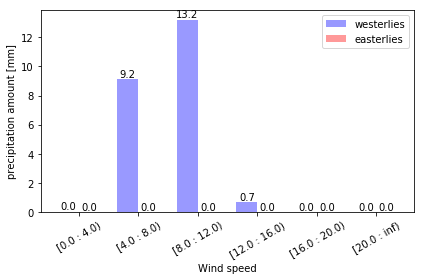

In [220]:
bar_width = 0.35
opacity = 0.4
bar1= plt.bar(np.arange(np.array(pre_west_ws).shape[0])-bar_width/2, np.array(pre_west_ws)[:,0], width = bar_width,
       align='center', alpha=opacity, color='b', label='westerlies')
bar2 = plt.bar(np.arange(np.array(pre_west_ws).shape[0])+bar_width/2, np.array(pre_west_ws)[:,1], width = bar_width,
       align='center', alpha=opacity, color='r', label='easterlies')

plt.xlabel('Wind speed')
plt.ylabel('precipitation amount [mm]')
plt.xticks(np.arange(np.array(pre_west_ws).shape[0]), 
           ['[0.0 : 4.0)', '[4.0 : 8.0)', '[8.0 : 12.0)', '[12.0 : 16.0)', '[16.0 : 20.0)', '[20.0 : inf)'],rotation=30)
# Add counts above the two bar graphs
for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%s' % str(np.round(height,1)), ha='center', va='bottom')

plt.legend()
plt.tight_layout()
plt.show()

### Eklima data

In [13]:
eklima_f = dict()
eklima_double_fence_acc = dict()
eklima_wind_dir_10m   = dict()
eklima_wind_speed_10m = dict()
eklima_diff = dict()
eklima_westerly_idx = dict()
eklima_easterly_idx = dict()
eklima_westerly = dict()
eklima_easterly = dict()
eklima_total_precip = dict()
eklima_precip_west  = dict()
eklima_precip_east  = dict()

for month in m:
    if month == '11':
        t = np.arange(8,31)
    if month == '12' or month == '01' or month == '03':
        t = np.arange(1,32)
    if month == '02':
        t = np.arange(1,29)
    if month == '11' or month == '12':
        year = '2016'
    if month == '01' or month == '02' or month == '03':
        year = '2017'
    

    for day in t:
        
        if day < 10:
            day = '0%s' %day
        else:
            day = '%s' %day

        eklima_dirnc = '../../Data/Eklima/%s/precip_wind_temp_%s%s%s.nc' %(station,year,month,day)
        eklima_f[int(year+month+day)] = netCDF4.Dataset(eklima_dirnc, 'r')

        eklima_double_fence_acc[int(year+month+day)] = (eklima_f[int(year+month+day)].variables['RR_1'][:])
        eklima_wind_dir_10m[int(year+month+day)]   = (eklima_f[int(year+month+day)].variables['DD'][:])
        eklima_wind_speed_10m[int(year+month+day)] = (eklima_f[int(year+month+day)].variables['FF'][:])
        
        eklima_f[int(year+month+day)].close
        

        ## calculate the precipitation difference, since the minutelty data is accumulated from the beginning
        eklima_diff[int(year+month+day)] = np.empty(shape=(eklima_double_fence_acc[int(year+month+day)].shape))#/60))
        eklima_diff[int(year+month+day)][:] =  np.nan

        eklima_diff[int(year+month+day)][:,] = eklima_double_fence_acc[int(year+month+day)]

        # Find wind regimes and associated precip amount
        IDX = np.arange(eklima_wind_dir_10m[int(year+month+day)].shape[0])

        ## find all eklima_westerly regimes (202.5 - 22.5 deg) 
        eklima_westerly_idx[int(year+month+day)]  = IDX[np.logical_or(np.logical_and((eklima_wind_dir_10m[int(year+month+day)][:,] >= 202.5),
                                                                                     (eklima_wind_dir_10m[int(year+month+day)][:,] <= 360)),
                                                                      (eklima_wind_dir_10m[int(year+month+day)][:,] <22.5))]

        ## find all eklima_easterly regimes (22.5 - 202.5 deg)
        eklima_easterly_idx[int(year+month+day)]  = IDX[np.logical_and((eklima_wind_dir_10m[int(year+month+day)][:,] >= 22.5),
                                                                       (eklima_wind_dir_10m[int(year+month+day)][:,] < 202.5))]

        eklima_westerly[int(year+month+day)] = eklima_westerly_idx[int(year+month+day)]
        eklima_easterly[int(year+month+day)] = eklima_easterly_idx[int(year+month+day)]

        if len(eklima_westerly[int(year+month+day)]) == 0:    # only easterlies
            eklima_easterly[int(year+month+day)]  = eklima_easterly[int(year+month+day)].astype(int)

            #print([int(year+month+day)], 
             #    'total precipitation [mm/24h]:', 
              #   np.round(np.nansum(eklima_diff[int(year+month+day)][eklima_easterly_idx[int(year+month+day)],]) + \
               #           np.nansum(eklima_diff[int(year+month+day)][eklima_westerly_idx[int(year+month+day)],]),2 ),
                # 'eklima_easterly [mm/24h]:', 
                 #np.round(np.nansum(eklima_diff[int(year+month+day)][eklima_easterly[int(year+month+day)],]),2),
                  #eklima_westerly [mm/24h]:', 
             #    np.round(len(eklima_westerly[int(year+month+day)]),2))

        elif len(eklima_easterly[int(year+month+day)]) == 0:  # only westerlies
            eklima_westerly[int(year+month+day)]  = eklima_westerly[int(year+month+day)].astype(int)

            #print([int(year+month+day)], 
             #    'total precipitation [mm/24h]:', 
              #   np.round(np.nansum(eklima_diff[int(year+month+day)][eklima_easterly_idx[int(year+month+day)],]) + \
               #           np.nansum(eklima_diff[int(year+month+day)][eklima_westerly_idx[int(year+month+day)],]),2 ),
                # 'eklima_easterly [mm/24h]:', 
                 #np.round(len(eklima_easterly[int(year+month+day)]),2),
                  #eklima_westerly [mm/24h]:', 
           #      np.round(np.nansum(eklima_diff[int(year+month+day)][eklima_westerly[int(year+month+day)],]),2))
        else:    # both easterlies and westerlies
            eklima_easterly[int(year+month+day)]  = eklima_easterly[int(year+month+day)].astype(int)
            eklima_westerly[int(year+month+day)]  = eklima_westerly[int(year+month+day)].astype(int)
            
            #print([int(year+month+day)], 
             #    'total precipitation [mm/24h]:', 
              #   np.round(np.nansum(eklima_diff[int(year+month+day)][eklima_easterly_idx[int(year+month+day)],]) + \
               #           np.nansum(eklima_diff[int(year+month+day)][eklima_westerly_idx[int(year+month+day)],]),2 ),
                # 'eklima_easterly [mm/24h]:', 
                 #np.round(np.nansum(eklima_diff[int(year+month+day)][eklima_easterly[int(year+month+day)],]),2),
                  #eklima_westerly [mm/24h]:', 
             #    np.round(np.nansum(eklima_diff[int(year+month+day)][eklima_westerly[int(year+month+day)],]),2))

        # assign sum values to days
        eklima_total_precip[int(year+month+day)] = np.nansum(eklima_diff[int(year+month+day)][eklima_easterly_idx[int(year+month+day)],]) + \
                                           np.nansum(eklima_diff[int(year+month+day)][eklima_westerly_idx[int(year+month+day)],])
        eklima_precip_east[int(year+month+day)] = np.nansum(eklima_diff[int(year+month+day)][eklima_easterly[int(year+month+day)],])
        eklima_precip_west[int(year+month+day)] = np.nansum(eklima_diff[int(year+month+day)][eklima_westerly[int(year+month+day)],])
        

        if obs_total_precip[int(year+month+day)] < 0:
            if obs_precip_east[int(year+month+day)] < 0 and obs_precip_west[int(year+month+day)] < 0:
#                #print([int(year+month+day)], 'all are negative',obs_total_precip[int(year+month+day)],obs_precip_east[int(year+month+day)],obs_precip_west[int(year+month+day)])
                obs_total_precip[int(year+month+day)] = eklima_total_precip[int(year+month+day)]
                obs_precip_east[int(year+month+day)] = eklima_precip_east[int(year+month+day)]
                obs_precip_west[int(year+month+day)] = eklima_precip_west[int(year+month+day)]
                obs_wind_speed_rolling[int(year+month+day)] = eklima_wind_speed_10m[int(year+month+day)]
                obs_wind_dir_rolling[int(year+month+day)] = eklima_wind_dir_10m[int(year+month+day)]
                obs_westerly[int(year+month+day)] = eklima_westerly[int(year+month+day)]
                obs_easterly[int(year+month+day)] = eklima_easterly[int(year+month+day)]
#                #print([int(year+month+day)], 'all are negative',obs_total_precip[int(year+month+day)],obs_precip_east[int(year+month+day)],obs_precip_west[int(year+month+day)])
    
            elif obs_precip_east[int(year+month+day)] < 0:
#                #print([int(year+month+day)], 'total and east',obs_total_precip[int(year+month+day)],obs_precip_east[int(year+month+day)])
                obs_total_precip[int(year+month+day)] = eklima_total_precip[int(year+month+day)]
                obs_precip_east[int(year+month+day)] = eklima_precip_east[int(year+month+day)]
                obs_precip_west[int(year+month+day)] = eklima_precip_west[int(year+month+day)]
                obs_wind_speed_rolling[int(year+month+day)] = eklima_wind_speed_10m[int(year+month+day)]
                obs_wind_dir_rolling[int(year+month+day)] = eklima_wind_dir_10m[int(year+month+day)]
                obs_westerly[int(year+month+day)] = eklima_westerly[int(year+month+day)]
                obs_easterly[int(year+month+day)] = eklima_easterly[int(year+month+day)]
#                #print([int(year+month+day)], 'total and east',obs_total_precip[int(year+month+day)],obs_precip_east[int(year+month+day)])
        
            elif obs_precip_west[int(year+month+day)] < 0:
#                #print([int(year+month+day)], 'total and west',obs_total_precip[int(year+month+day)],obs_precip_west[int(year+month+day)])
                obs_total_precip[int(year+month+day)] = eklima_total_precip[int(year+month+day)]
                obs_precip_east[int(year+month+day)] = eklima_precip_east[int(year+month+day)]
                obs_precip_west[int(year+month+day)] = eklima_precip_west[int(year+month+day)]
                obs_wind_speed_rolling[int(year+month+day)] = eklima_wind_speed_10m[int(year+month+day)]
                obs_wind_dir_rolling[int(year+month+day)] = eklima_wind_dir_10m[int(year+month+day)]
                obs_westerly[int(year+month+day)] = eklima_westerly[int(year+month+day)]
                obs_easterly[int(year+month+day)] = eklima_easterly[int(year+month+day)]
#                #print([int(year+month+day)], 'total and west',obs_total_precip[int(year+month+day)],obs_precip_west[int(year+month+day)])
        
        elif obs_precip_east[int(year+month+day)] < 0:
#            #print([int(year+month+day)], 'only east',obs_precip_east[int(year+month+day)])
            obs_total_precip[int(year+month+day)] = eklima_total_precip[int(year+month+day)]
            obs_precip_east[int(year+month+day)] = eklima_precip_east[int(year+month+day)]
            obs_precip_west[int(year+month+day)] = eklima_precip_west[int(year+month+day)]
            obs_wind_speed_rolling[int(year+month+day)] = eklima_wind_speed_10m[int(year+month+day)]
            obs_wind_dir_rolling[int(year+month+day)] = eklima_wind_dir_10m[int(year+month+day)]
            obs_westerly[int(year+month+day)] = eklima_westerly[int(year+month+day)]
            obs_easterly[int(year+month+day)] = eklima_easterly[int(year+month+day)]
#            #print([int(year+month+day)], 'only east',obs_precip_east[int(year+month+day)])   
    
        elif obs_precip_west[int(year+month+day)] < 0:
#            #print([int(year+month+day)], 'only west',obs_precip_west[int(year+month+day)])
            obs_total_precip[int(year+month+day)] = eklima_total_precip[int(year+month+day)]
            obs_precip_east[int(year+month+day)] = eklima_precip_east[int(year+month+day)]
            obs_precip_west[int(year+month+day)] = eklima_precip_west[int(year+month+day)]
            obs_wind_speed_rolling[int(year+month+day)] = eklima_wind_speed_10m[int(year+month+day)]
            obs_wind_dir_rolling[int(year+month+day)] = eklima_wind_dir_10m[int(year+month+day)]
            obs_westerly[int(year+month+day)] = eklima_westerly[int(year+month+day)]
            obs_easterly[int(year+month+day)] = eklima_easterly[int(year+month+day)]
#            #print([int(year+month+day)], 'only west',obs_precip_west[int(year+month+day)])
    

### MEPS data

In [14]:
def fill_values(variable):
    if np.ma.is_masked(variable):
        mask = np.ma.getmaskarray(variable[:,:,:])
        marr = np.ma.array(variable[:,:,:], mask = mask, fill_value = np.nan)
        filled = marr.filled(np.nan)
        
    else:
        filled = variable[:]
        
    return(filled)

In [15]:
meps_f = dict()
meps_precip_acc = dict()
meps_xwind_10m = dict()
meps_ywind_10m = dict()
meps_diff = dict()
meps_wind_dir   = dict()
meps_wind_speed = dict()
meps_westerly_idx = dict()
meps_easterly_idx = dict()
meps_westerly = dict()
meps_easterly = dict()
meps_total_precip = dict()
meps_precip_west  = dict()
meps_precip_east  = dict()

for month in m:
    if month == '11':
        t = np.arange(8,31)
    if month == '12' or month == '01' or month == '03':
        t = np.arange(1,32)
    if month == '02':
        t = np.arange(1,29)
    if month == '11' or month == '12':
        year = '2016'
    if month == '01' or month == '02' or month == '03':
        year = '2017'
    

    for day in t:
        
        if day < 10:
            day = '0%s' %day
        else:
            day = '%s' %day

        meps_dirnc = '../../Data/MEPS/%s/%s%s/sfc_hybrid5_allEM_00/%s%s%s_00.nc' %(station,year,month,year,month,day)
        try:
            meps_f[int(year+month+day)] = netCDF4.Dataset(meps_dirnc, 'r')
        except OSError:
            #print('no file found: %s' %meps_dirnc)
#            meps_precip_acc[int(year+month+day)] = np.empty(shape=(67, 1, 10))
 #           meps_xwind_10m[int(year+month+day)] = np.empty(shape=(67, 1, 10))
  #          meps_ywind_10m[int(year+month+day)] = np.empty(shape=(67, 1, 10))
            
            meps_total_precip[int(year+month+day)] = np.empty(shape=(10, ))
            meps_total_precip[int(year+month+day)][:] = np.nan
            meps_precip_east[int(year+month+day)] = np.empty(shape=(10, ))
            meps_precip_east[int(year+month+day)][:] = np.nan
            meps_precip_west[int(year+month+day)] = np.empty(shape=(10, ))
            meps_precip_west[int(year+month+day)][:] = np.nan
            meps_wind_dir[int(year+month+day)] = np.empty(shape=(25,1,10))
            meps_wind_dir[int(year+month+day)][:,:,:] = np.nan
            continue

        meps_precip_acc[int(year+month+day)] = (meps_f[int(year+month+day)].variables['precipitation_amount_acc'][:])
        meps_xwind_10m[int(year+month+day)] = (meps_f[int(year+month+day)].variables['x_wind_10m'][:])
        meps_ywind_10m[int(year+month+day)] = (meps_f[int(year+month+day)].variables['y_wind_10m'][:])
        
        ## substitute missing values with nan
        meps_precip_acc[int(year+month+day)] = fill_values(meps_precip_acc[int(year+month+day)][:,:,:])
        meps_xwind_10m[int(year+month+day)] = fill_values(meps_xwind_10m[int(year+month+day)][:,:,:])
        meps_ywind_10m[int(year+month+day)] = fill_values(meps_ywind_10m[int(year+month+day)][:,:,:])
        
#        meps_wind_dir_10m[int(year+month+day)]   = (meps_f[int(year+month+day)].variables['10m_wind_dir_mast1'][:])
#        meps_wind_speed_10m[int(year+month+day)] = (meps_f[int(year+month+day)].variables['10m_wind_speed_mast1'][:])
        
        meps_f[int(year+month+day)].close
        

        ## calculate the precipitation difference, since the minutelty data is accumulated from the beginning
        meps_diff[int(year+month+day)] = np.empty(shape=(meps_precip_acc[int(year+month+day)].shape))#/60))
        meps_diff[int(year+month+day)][:] =  np.nan

        for i in np.arange(0,meps_precip_acc[int(year+month+day)].shape[0]-1):
            meps_diff[int(year+month+day)][int(i),:,:] = meps_precip_acc[int(year+month+day)][int(i)+1,:,:] - \
                                                         meps_precip_acc[int(year+month+day)][int(i),:,:]

        #### calculate wind direction / speed
        meps_wind_dir[int(year+month+day)] = np.arctan2(meps_ywind_10m[int(year+month+day)][:,:,:], 
                                                        meps_xwind_10m[int(year+month+day)][:,:,:]) 
        meps_wind_dir[int(year+month+day)] = 270 - np.rad2deg(meps_wind_dir[int(year+month+day)])
        larger360 = np.where(meps_wind_dir[int(year+month+day)][:,:,:] > 360.)
        meps_wind_dir[int(year+month+day)][larger360] = meps_wind_dir[int(year+month+day)][larger360]-360
    
        meps_wind_speed[int(year+month+day)] = np.sqrt((meps_xwind_10m[int(year+month+day)][:,:,:])**2 + \
                                                           (meps_ywind_10m[int(year+month+day)][:,:,:])**2 )
        
        ### only get values up to 24h
        meps_diff[int(year+month+day)] = meps_diff[int(year+month+day)][:25,:,:]
        meps_wind_dir[int(year+month+day)] = meps_wind_dir[int(year+month+day)][:25,:,:]
        meps_wind_speed[int(year+month+day)] = meps_wind_speed[int(year+month+day)][:25,:,:]

        # Find wind regimes and associated precip amount
        IDX = np.arange(meps_wind_dir[int(year+month+day)].shape[0])

        meps_westerly_idx[int(year+month+day)] = []
        meps_easterly_idx[int(year+month+day)] = []

        for ens_memb in range(10):
            ## find all meps_westerly regimes (202.5 - 22.5 deg) 
            meps_westerly_idx[int(year+month+day)].append(IDX[np.logical_or(
                    np.logical_and((meps_wind_dir[int(year+month+day)][:,0,ens_memb] >= 202.5), 
                                   (meps_wind_dir[int(year+month+day)][:,0,ens_memb] <= 360)),
                    (meps_wind_dir[int(year+month+day)][:,0,ens_memb] <22.5))])
#        #print(np.array(meps_westerly_idx[int(year+month+day)][ens_memb]).shape)


            ## find all meps_easterly regimes (22.5 - 202.5 deg)
            meps_easterly_idx[int(year+month+day)].append(IDX[np.logical_and(
                    (meps_wind_dir[int(year+month+day)][:,0,ens_memb] >= 22.5),
                    (meps_wind_dir[int(year+month+day)][:,0,ens_memb] < 202.5))])
#        #print(np.array(meps_easterly_idx[int(year+month+day)][ens_memb]).shape)

        
        meps_westerly[int(year+month+day)] = meps_westerly_idx[int(year+month+day)]
        meps_easterly[int(year+month+day)] = meps_easterly_idx[int(year+month+day)]
        
        meps_easterly_idx[int(year+month+day)] = np.array(meps_easterly_idx[int(year+month+day)])
        meps_westerly_idx[int(year+month+day)] = np.array(meps_westerly_idx[int(year+month+day)])

        meps_total_precip[int(year+month+day)] = []
        meps_precip_east[int(year+month+day)] = []
        meps_precip_west[int(year+month+day)] = []

        for ens_memb in range(10):
 #           if len(meps_westerly[int(year+month+day)][ens_memb]) == 0:    # only easterlies
                #print([int(year+month+day)], 
                 # 'total precipitation [mm/24h]:', 'EM=%s' %ens_memb,
                  #np.round(np.nansum(meps_diff[int(year+month+day)][meps_easterly_idx[int(year+month+day)][ens_memb],:,ens_memb]) + \
                   #        np.nansum(meps_diff[int(year+month+day)][meps_westerly_idx[int(year+month+day)][ens_memb],:,ens_memb]),2 ),
              #    'meps_easterly [mm/24h]:', 
               #   np.round(np.nansum(meps_diff[int(year+month+day)][meps_easterly_idx[int(year+month+day)][ens_memb],:,ens_memb]),2),
                #  'meps_westerly [mm/24h]:', 
                 # np.round(len(meps_westerly[int(year+month+day)][ens_memb]),2))

  #          elif len(meps_easterly[int(year+month+day)][ens_memb]) == 0:  # only westerlies
                #print([int(year+month+day)], 
                 # 'total precipitation [mm/24h]:', 'EM=%s' %ens_memb,
                  #np.round(np.nansum(meps_diff[int(year+month+day)][meps_easterly_idx[int(year+month+day)][ens_memb],:,ens_memb]) + \
                   #        np.nansum(meps_diff[int(year+month+day)][meps_westerly_idx[int(year+month+day)][ens_memb],:,ens_memb]),2 ),
   #               'meps_easterly [mm/24h]:', 
    #              np.round(len(meps_easterly[int(year+month+day)][ens_memb]),2),
     #             'meps_westerly [mm/24h]:', 
      #            np.round(np.nansum(meps_diff[int(year+month+day)][meps_westerly_idx[int(year+month+day)][ens_memb],:,ens_memb]),2))

   #         else:    # both easterlies and westerlies
                #print([int(year+month+day)], 
                 # 'total precipitation [mm/24h]:', 'EM=%s' %ens_memb,
                  #np.round(np.nansum(meps_diff[int(year+month+day)][meps_easterly_idx[int(year+month+day)][ens_memb],:,ens_memb]) + \
                   #        np.nansum(meps_diff[int(year+month+day)][meps_westerly_idx[int(year+month+day)][ens_memb],:,ens_memb]),2 ),
      #            'meps_easterly [mm/24h]:', 
       #           np.round(np.nansum(meps_diff[int(year+month+day)][meps_easterly_idx[int(year+month+day)][ens_memb],:,ens_memb]),2),
        #          'meps_westerly [mm/24h]:', 
         #         np.round(np.nansum(meps_diff[int(year+month+day)][meps_westerly_idx[int(year+month+day)][ens_memb],:,ens_memb]),2))
            

            # assign sum values to days
            total = np.nansum(meps_diff[int(year+month+day)][meps_easterly_idx[int(year+month+day)][ens_memb],:,ens_memb]) + \
                    np.nansum(meps_diff[int(year+month+day)][meps_westerly_idx[int(year+month+day)][ens_memb],:,ens_memb])
            meps_total_precip[int(year+month+day)].append(total)
    
            easterly = np.nansum(meps_diff[int(year+month+day)][meps_easterly_idx[int(year+month+day)][ens_memb],:,ens_memb])
            meps_precip_east[int(year+month+day)].append(easterly)
    
            westerly = np.nansum(meps_diff[int(year+month+day)][meps_westerly_idx[int(year+month+day)][ens_memb],:,ens_memb])
            meps_precip_west[int(year+month+day)].append(westerly)
            
            ### for plotting: for values smaller 22.5 add 360deg
            if np.where(meps_wind_dir[int(year+month+day)][:,0,ens_memb] <22.5):
                meps_wind_dir[int(year+month+day)][np.where(meps_wind_dir[int(year+month+day)][:,0,ens_memb]  <22.5),0,ens_memb] = meps_wind_dir[int(year+month+day)][np.where(meps_wind_dir[int(year+month+day)][:,0,ens_memb]  <22.5),0,ens_memb]+360 
                
        
        if np.where(obs_wind_dir_rolling[int(year+month+day)] <22.5):
            obs_wind_dir_rolling[int(year+month+day)][np.where(obs_wind_dir_rolling[int(year+month+day)] <22.5)] = obs_wind_dir_rolling[int(year+month+day)][np.where(obs_wind_dir_rolling[int(year+month+day)] <22.5)]+360.
    

In [16]:
### Define colorbar colors
champ = 255.
memb_col = np.array([99,99,99])/champ       # ensemble member color
obs_col = np.array([108, 26, 200])/champ


for month in m:
    if month == '11':
        t = np.arange(8,31)
    if month == '12' or month == '01' or month == '03':
        t = np.arange(1,32)
    if month == '02':
        t = np.arange(1,29)
    if month == '11' or month == '12':
        year = '2016'
    if month == '01' or month == '02' or month == '03':
        year = '2017'
    

    for day in t:
        
        if day < 10:
            day = '0%s' %day
        else:
            day = '%s' %day
            
        fig = plt.figure(figsize=(8,2.67))

        fig.text(.0, .5, '10m - Wind direction [$^{o}$]', ha='center', va='center', rotation='vertical', fontsize = 16)
##########################################################
        ax1 = fig.add_subplot(111)

        for ens_memb in np.arange(2,10):
            ax1.plot(np.arange(meps_wind_dir[int(year+month+day)][:,:,ens_memb].shape[0]*60)[::60],
                     meps_wind_dir[int(year+month+day)][:,:,ens_memb], color = memb_col, linestyle= '-', label='_nolegend_')
        ax1.plot(np.arange(meps_wind_dir[int(year+month+day)][:,:,1].shape[0]*60)[::60],
             meps_wind_dir[int(year+month+day)][:,:,1], color = memb_col, linestyle = '-', label = 'ensemble member')
        ax1.plot(np.arange(meps_wind_dir[int(year+month+day)][:,:,0].shape[0]*60)[::60],
                 meps_wind_dir[int(year+month+day)][:,:,0], 'k', linewidth = 2, 
                 label = 'deterministic')
        if obs_wind_dir_rolling[int(year+month+day)].shape[0] == 24:
            ax1.plot(np.arange(60,obs_wind_dir_rolling[int(year+month+day)].shape[0]*60+60)[::60],
                    obs_wind_dir_rolling[int(year+month+day)][:], marker= '.', linestyle='-', color = obs_col, label = 'observation')
        else:
            ax1.plot(np.arange(obs_wind_dir_rolling[int(year+month+day)].shape[0]),
                 obs_wind_dir_rolling[int(year+month+day)][:], '.', color = obs_col, label = 'observation')#, markersize = 2)
        
        for k in np.arange(45,360,90):
            ax1.hlines(k,0,meps_wind_dir[int(year+month+day)][:,:,0].shape[0]*60, linestyles='dashed', linewidth = 1)
        for k in np.arange(0,360,90):
            ax1.hlines(k,0,meps_wind_dir[int(year+month+day)][:,:,0].shape[0]*60, linewidth = 1)
#        ax1.hlines(135,0,meps_wind_dir[int(year+month+day)][:,:,0].shape[0]*60, linestyles='dashed', linewidth = 1)
 #       ax1.hlines(180,0,meps_wind_dir[int(year+month+day)][:,:,0].shape[0]*60, linewidth = 1)
  #      ax1.hlines(225,0,meps_wind_dir[int(year+month+day)][:,:,0].shape[0]*60, linestyles='dashed', linewidth = 1)
   #     ax1.hlines(270,0,obs_wind_dir_rolling[int(year+month+day)].shape[0], linewidth = 1)
    #    ax1.hlines(315,0,obs_wind_dir_rolling[int(year+month+day)].shape[0], linestyles='dashed', linewidth = 1)

        ax1.fill_between(np.arange(meps_wind_dir[int(year+month+day)][:,:,0].shape[0]*60), 202.5, 360+22.5,  facecolor='gray', alpha=0.4)
#        ax1.fill_between(np.arange(meps_wind_dir[int(year+month+day)][:,:,0].shape[0]*60), 0, 22.5,  facecolor='gray', alpha=0.4)

        ax1.set_xlim([0, meps_wind_dir[int(year+month+day)][:,:,0].shape[0]*60-60])
#        ax1.set_ylim([0, 360])
        ax1.set_ylim([22.5, 360+22.5])
        ax1.set_xticks(np.arange(0,meps_wind_dir[int(year+month+day)][:,:,0].shape[0]*60,120))    
        ax1.set_xticklabels([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24 ])
        ax1.set_yticks([22.5, 45, 90, 135, 180, 225,270,315,360])
#        ax1.set_yticklabels(['N', '', 'E', '', 'S', '', 'W', '', 'N' ])
        ax1.set_yticklabels(['22.5', '', 'E', '', 'S', '', 'W', '', 'N' ])
        fig.suptitle("%s-%s-%s" %(year,month,day), fontsize=14,fontweight='bold')
        ax1.tick_params(labelsize=14)

        lgd = ax1.legend(loc = 'center right', bbox_to_anchor = (1.54,0.26), 
                         fancybox=True, shadow=True, ncol=1, fontsize=16)

        fig_name = '%s%s%s_00.%s' %(year,month,day,form)
        if savefig == 1:
            cF.createFolder('%s/%s%s' %(figdir,year,month))
            plt.savefig('%s/%s%s/%s' %(figdir,year,month, fig_name), format = form, bbox_inches ='tight')
            print('plot saved: %s/%s%s/%s' %(figdir,year,month, fig_name))
        else:
            plt.show()
    
        plt.close()

plot saved: ../../Figures/Weathermast_MEPS/Haukeliseter/wind_dir/201611/20161108_00.png
plot saved: ../../Figures/Weathermast_MEPS/Haukeliseter/wind_dir/201611/20161109_00.png
plot saved: ../../Figures/Weathermast_MEPS/Haukeliseter/wind_dir/201611/20161110_00.png
plot saved: ../../Figures/Weathermast_MEPS/Haukeliseter/wind_dir/201611/20161111_00.png
plot saved: ../../Figures/Weathermast_MEPS/Haukeliseter/wind_dir/201611/20161112_00.png
plot saved: ../../Figures/Weathermast_MEPS/Haukeliseter/wind_dir/201611/20161113_00.png
plot saved: ../../Figures/Weathermast_MEPS/Haukeliseter/wind_dir/201611/20161114_00.png
plot saved: ../../Figures/Weathermast_MEPS/Haukeliseter/wind_dir/201611/20161115_00.png
plot saved: ../../Figures/Weathermast_MEPS/Haukeliseter/wind_dir/201611/20161116_00.png
plot saved: ../../Figures/Weathermast_MEPS/Haukeliseter/wind_dir/201611/20161117_00.png
plot saved: ../../Figures/Weathermast_MEPS/Haukeliseter/wind_dir/201611/20161118_00.png
plot saved: ../../Figures/Weathe

plot saved: ../../Figures/Weathermast_MEPS/Haukeliseter/wind_dir/201702/20170210_00.png
plot saved: ../../Figures/Weathermast_MEPS/Haukeliseter/wind_dir/201702/20170211_00.png
plot saved: ../../Figures/Weathermast_MEPS/Haukeliseter/wind_dir/201702/20170212_00.png
plot saved: ../../Figures/Weathermast_MEPS/Haukeliseter/wind_dir/201702/20170213_00.png
plot saved: ../../Figures/Weathermast_MEPS/Haukeliseter/wind_dir/201702/20170214_00.png
plot saved: ../../Figures/Weathermast_MEPS/Haukeliseter/wind_dir/201702/20170215_00.png
plot saved: ../../Figures/Weathermast_MEPS/Haukeliseter/wind_dir/201702/20170216_00.png
plot saved: ../../Figures/Weathermast_MEPS/Haukeliseter/wind_dir/201702/20170217_00.png
plot saved: ../../Figures/Weathermast_MEPS/Haukeliseter/wind_dir/201702/20170218_00.png
plot saved: ../../Figures/Weathermast_MEPS/Haukeliseter/wind_dir/201702/20170219_00.png
plot saved: ../../Figures/Weathermast_MEPS/Haukeliseter/wind_dir/201702/20170220_00.png
plot saved: ../../Figures/Weathe